In [1]:
import os,sys
from glob import glob
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib
import fiona
import rasterio as rio

# helpers
from xarr_helpers import *

from pysptools.material_count.vd import HfcVd
import pysptools.eea as eea #endmembers extraction algorithms
import pysptools.abundance_maps as amap
import pysptools.classification as cls
from pysptools.distance import SAM, NormXCorr  
import pysptools.material_count as cnt

from earthpy.spatial import bytescale

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

In [2]:
# load the table mountain shapefile
point_file = r"../arc/headwall_neon_CUSouth_poi.shp"
gdf1 = gpd.read_file(point_file)
print('point CRS: {}'.format(gdf1.crs))



point CRS: {'init': 'epsg:32613'}


In [3]:
gdf = gdf1.drop(1).reset_index()
gdf_4326 = gdf.to_crs(epsg=4326)
gdf_4326.head()

,index,Id,comments,geometry
0,0,0,dirt parking lot,POINT (-105.2320413087213 39.97927552633687)
1,2,0,tennis court (south),POINT (-105.2321048858712 39.97956622917603)
2,3,0,red hut,POINT (-105.2320315564236 39.9796903363637)
3,4,0,grass patch (south),POINT (-105.2319140238961 39.97865502556768)
4,5,0,leaf off tree,POINT (-105.2320006579609 39.97880026728588)


In [4]:
# NEON data files
data_dirs = !ls -d ../neon_data/*
neon_radiance_file = data_dirs[1] + '/L1/Spectrometer/RadianceH5/2019040920/NEON_D10_V10C_DP1_20190409_221206_radiance.h5'
neon_reflectance_file = data_dirs[1] + '/L1/Spectrometer/ReflectanceH5/2019040920/NEON_D10_V10C_DP1_20190409_221206_reflectance.h5'

# Headwall data files. Currently, only the Surface Reflectance products have been downloaded.
data_dirs_SWIR = !ls -d ../headwall_data/SWIR/*
data_dirs_VNIR = !ls -d ../headwall_data/VNIR/*

# first two directories will be from table mountain. second two are from tennis courts @ CU South
reflectance_files_VNIR_april10 = glob(data_dirs_VNIR[3] + '/*.hdr')
reflectance_files_VNIR_april10 = [f[:-4] for f in reflectance_files_VNIR_april10] # remove the .hdr

reflectance_files_SWIR_april10 = glob(data_dirs_SWIR[3] + '/*.hdr')
reflectance_files_SWIR_april10 = [f[:-4] for f in reflectance_files_SWIR_april10] # remove the .hdr

In [5]:
data_file_NEON = neon_reflectance_file

neon_id = os.path.basename(data_file_NEON).split('_')[2] # e.g., 'R10C'
print('NEON ID: ', neon_id)

NEON ID:  V10C


In [6]:
data_file_VNIR = reflectance_files_VNIR_april10[0]
data_file_SWIR = reflectance_files_SWIR_april10[0]
xarr_VNIR = xr.open_rasterio(data_file_VNIR, chunks=(256, 256, 256))
xarr_SWIR = xr.open_rasterio(data_file_SWIR, chunks=(256, 256, 256))
x_vnir, y_vnir = xarr_VNIR.coords['x'].values, xarr_VNIR.coords['y'].values
x_swir, y_swir = xarr_SWIR.coords['x'].values, xarr_SWIR.coords['y'].values

In [7]:
# then NEON (dask chunking done in-function)
x_neon, y_neon, xarr_NEON = NEON_create_refl_xarr_from_h5_file(data_file_NEON, nid=neon_id)



D:\projects\headwall_neon\notebooks\xarr_helpers.py:75: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  crs_str = f[nid]['Reflectance']['Metadata']['Coordinate_System']['Coordinate_System_String'].value
D:\projects\headwall_neon\notebooks\xarr_helpers.py:76: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  crs_epsg = f[nid]['Reflectance']['Metadata']['Coordinate_System']['EPSG Code'].value
D:\projects\headwall_neon\notebooks\xarr_helpers.py:77: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  crs_mapinfo = f[nid]['Reflectance']['Metadata']['Coordinate_System']['Map_Info'].value
D:\projects\headwall_neon\notebooks\xarr_helpers.py:78: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  crs_proj4 = f[nid]['Reflectance']['Metadata']['Coordinate_System']['Proj4'].value


In [8]:
xarr_NEON.shape

(13313, 903, 426)

In [9]:
# get a headwall dataset extent
XMIN, YMIN = -100, 40
XMAX, YMAX = -110, 30

xmin, xmax = x_vnir.min(), x_vnir.max()
ymin, ymax = y_vnir.min(), y_vnir.max()
    

if xmin < XMIN:
    XMIN = xmin
if xmax > XMAX:
    XMAX = xmax
if ymin < YMIN:
    YMIN = ymin
if ymax > YMAX:
    YMAX = ymax

print(XMIN, YMIN, XMAX, YMAX)


-105.23221071371388 39.977907290428455 -105.23184026231316 39.97988019607846


In [10]:
# subset the NEON data with the full extent of headwall data cubes
from shapely.geometry import mapping, box

bbox = box(XMIN, YMIN, XMAX, YMAX)
chunk1 = gpd.GeoDataFrame({'geometry':[bbox]}, crs=fiona.crs.from_epsg(4326)).to_crs(epsg=32613)

neon_sub_cube, neon_arrs = extract_from_NEON((xarr_NEON, x_neon, y_neon), chunk1)
neon_wav, full_neon = neon_arrs

# Use spatial extraction to generate the endmember spectra, and use SAM calculation to plot the spectral distance maps

In [11]:
ds_neon = xr.Dataset(coords={'y':y_neon, 'x':x_neon})
shapes = [(shape, n) for n, shape in enumerate(gdf.geometry)]

temp=[]
for shape in shapes:
    ds_neon['aoi'] = rasterize([shape], ds_neon.coords)
    ds_neon['aoi'] = ds_neon.aoi*0 + 1

    example_neon = ds_neon.aoi * xarr_NEON

    val_y, val_x = np.where(ds_neon.aoi==1)
    u_y = np.unique(val_y)
    u_x = np.unique(val_x)
    ex_neon = example_neon.sel(y=y_neon[val_y], x=x_neon[val_x])

    temp.append(np.squeeze(ex_neon))

neon_pt_em = np.vstack(temp)
neon_pt_em.shape

(5, 426)

In [12]:
# mask the absorption bands 1340-1445, 1790-1955
i_1340 = np.where(neon_wav >= 1340)[0][0]
i_1445 = np.where(neon_wav >= 1445)[0][0]
i_1790 = np.where(neon_wav >= 1790)[0][0]
i_1995 = np.where(neon_wav >= 1995)[0][0]


In [13]:
neon_shp = neon_sub_cube.shape
neon_reshp = neon_sub_cube.values.reshape(neon_shp[0]*neon_shp[1], neon_shp[2])

neon_reshp[:,i_1340:i_1445] = np.nan
neon_reshp[:,i_1790:i_1995] = np.nan


In [14]:
def nandot(v1, v2):
    v1_m = np.ma.array(v1, mask=np.isnan(v1))
    v2_m = np.ma.array(v2, mask=np.isnan(v2))

    return np.ma.dot(v1_m, v2_m)

def nansam(v1, v2):
    
    v1_m = np.ma.array(v1, mask=np.isnan(v1))
    v2_m = np.ma.array(v2, mask=np.isnan(v2))
    
    num = np.ma.sum(v1_m*v2_m)
    den1 = np.ma.sqrt(np.ma.sum(v1_m*v1_m))
    den2 = np.ma.sqrt(np.ma.sum(v2_m*v2_m))
    den = den1*den2
    
    return np.arccos(num/den)
    
    #return np.arccos(np.nansum(np.nanprod(v1,v2)) / (np.sqrt(np.nanprod(v1, v1)) * np.sqrt(np.nanprod(v2,v2))))

neon_pt_em[:,i_1340:i_1445] = np.nan
neon_pt_em[:,i_1790:i_1995] = np.nan
test1 = np.array([[SAM(sample, em) for sample in neon_reshp] for em in neon_pt_em])
test1 = np.array([[nansam(sample, em) for sample in neon_reshp] for em in neon_pt_em])

C:\software\anaconda3\envs\geo_py\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Warning: converting a masked element to nan.


In [15]:
test1.shape, neon_sub_cube.shape

((5, 7008), (219, 32, 426))

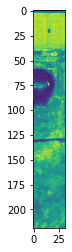

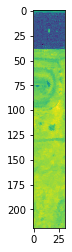

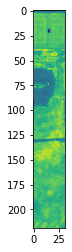

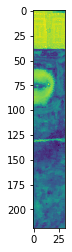

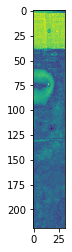

In [16]:
for smap in test1:
    plt.figure()
    plt.imshow(smap.reshape((neon_shp[0],neon_shp[1])))
    plt.show()

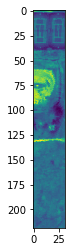

In [17]:
plt.imshow(neon_sub_cube[:,:,34])

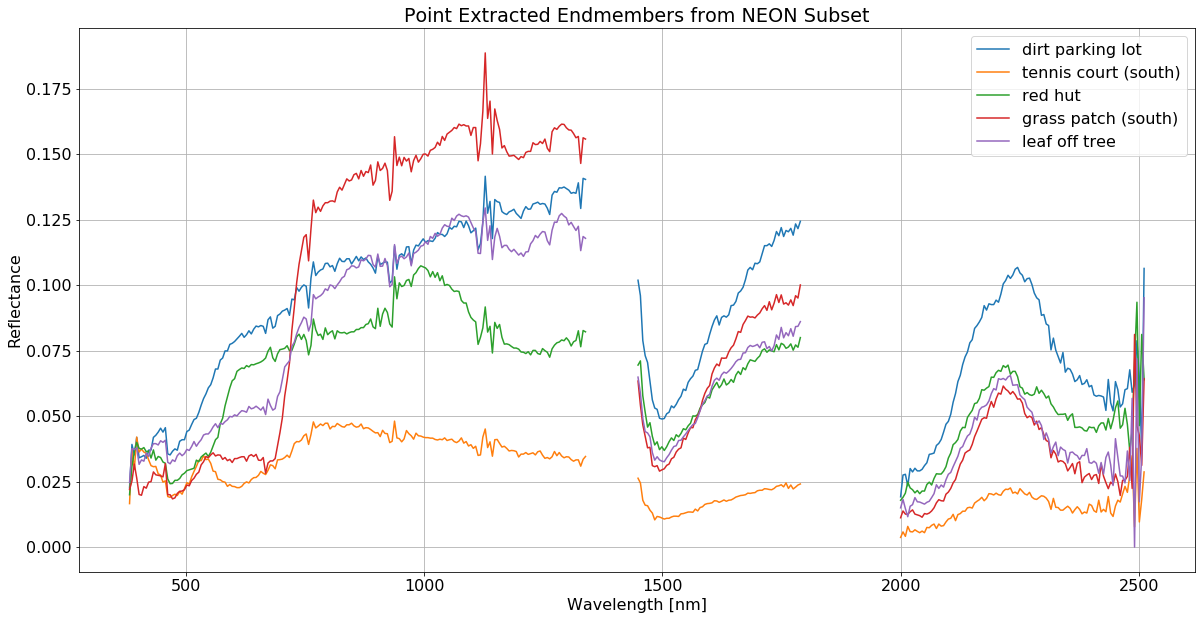

C:\software\anaconda3\envs\geo_py\lib\site-packages\earthpy\spatial.py:554: RuntimeWarning: invalid value encountered in greater
  data[data > cmax] = cmax
C:\software\anaconda3\envs\geo_py\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Warning: converting a masked element to nan.


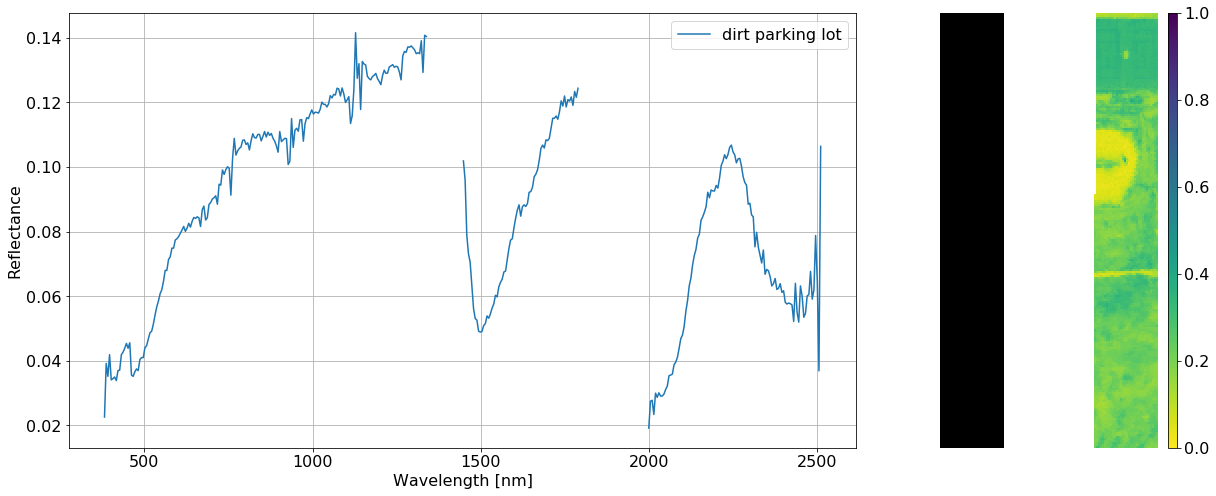

C:\software\anaconda3\envs\geo_py\lib\site-packages\earthpy\spatial.py:554: RuntimeWarning: invalid value encountered in greater
  data[data > cmax] = cmax
C:\software\anaconda3\envs\geo_py\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Warning: converting a masked element to nan.


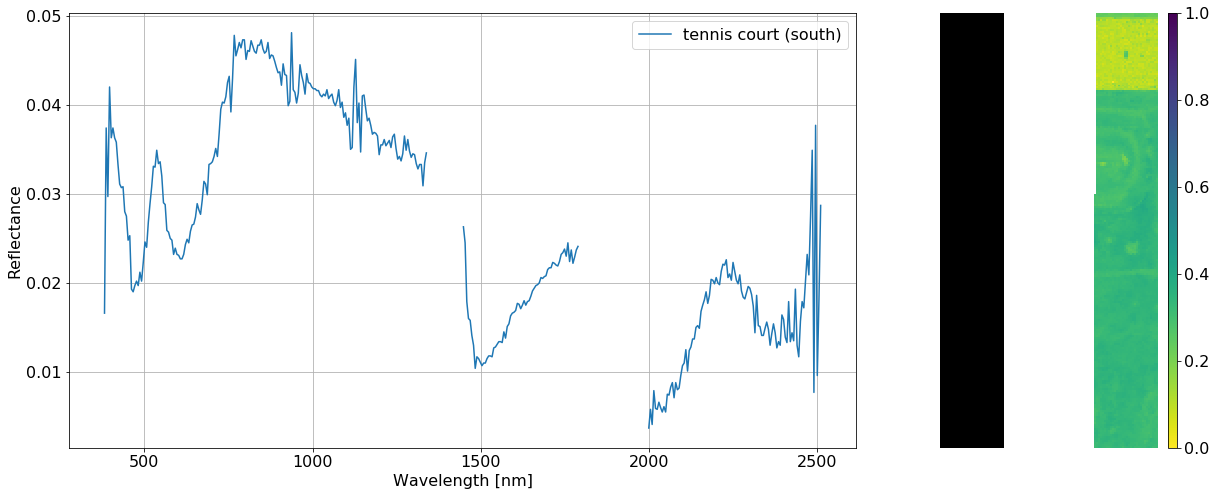

C:\software\anaconda3\envs\geo_py\lib\site-packages\earthpy\spatial.py:554: RuntimeWarning: invalid value encountered in greater
  data[data > cmax] = cmax
C:\software\anaconda3\envs\geo_py\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Warning: converting a masked element to nan.


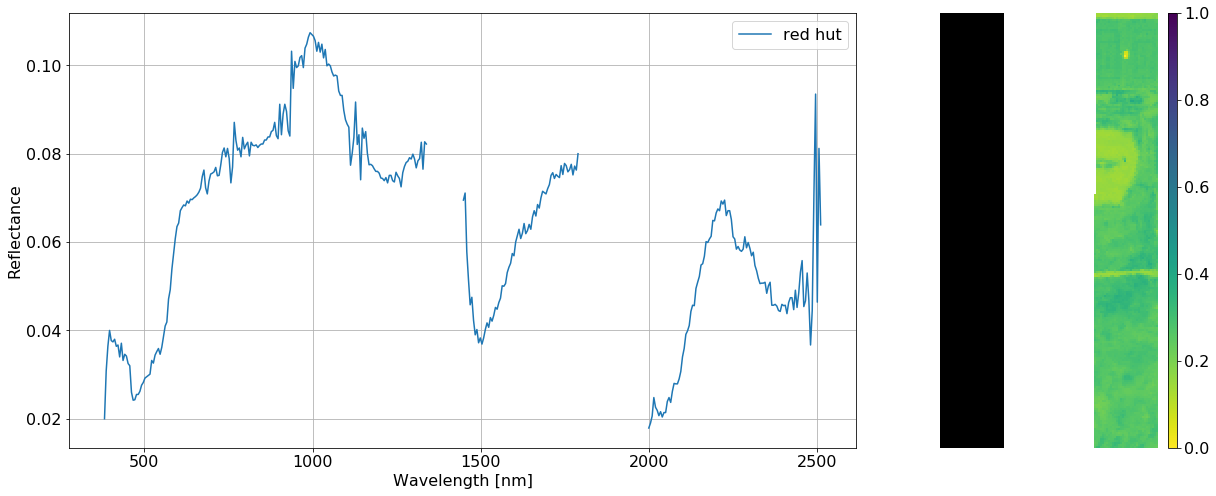

C:\software\anaconda3\envs\geo_py\lib\site-packages\earthpy\spatial.py:554: RuntimeWarning: invalid value encountered in greater
  data[data > cmax] = cmax
C:\software\anaconda3\envs\geo_py\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Warning: converting a masked element to nan.


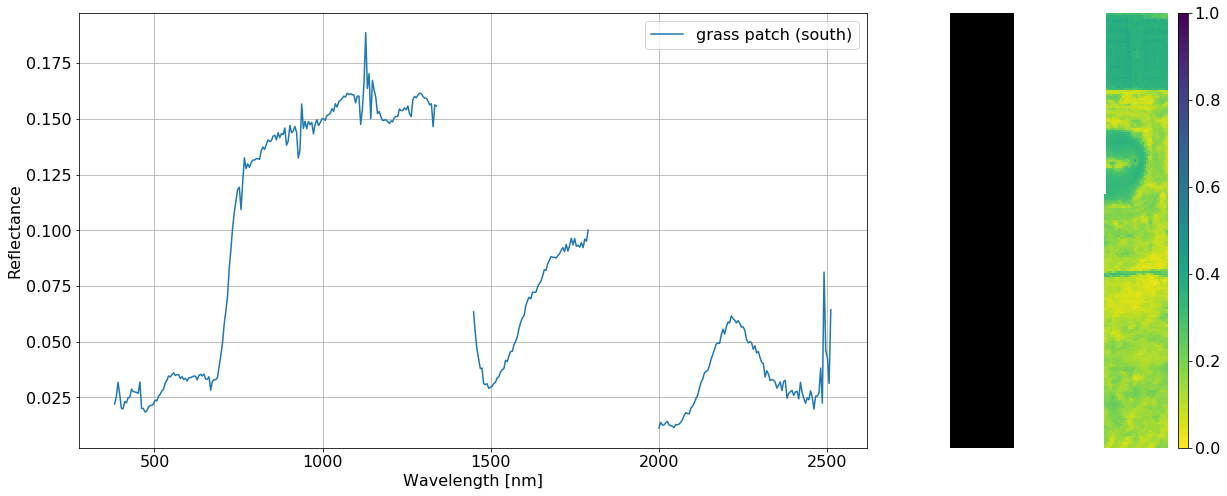

C:\software\anaconda3\envs\geo_py\lib\site-packages\earthpy\spatial.py:554: RuntimeWarning: invalid value encountered in greater
  data[data > cmax] = cmax
C:\software\anaconda3\envs\geo_py\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Warning: converting a masked element to nan.


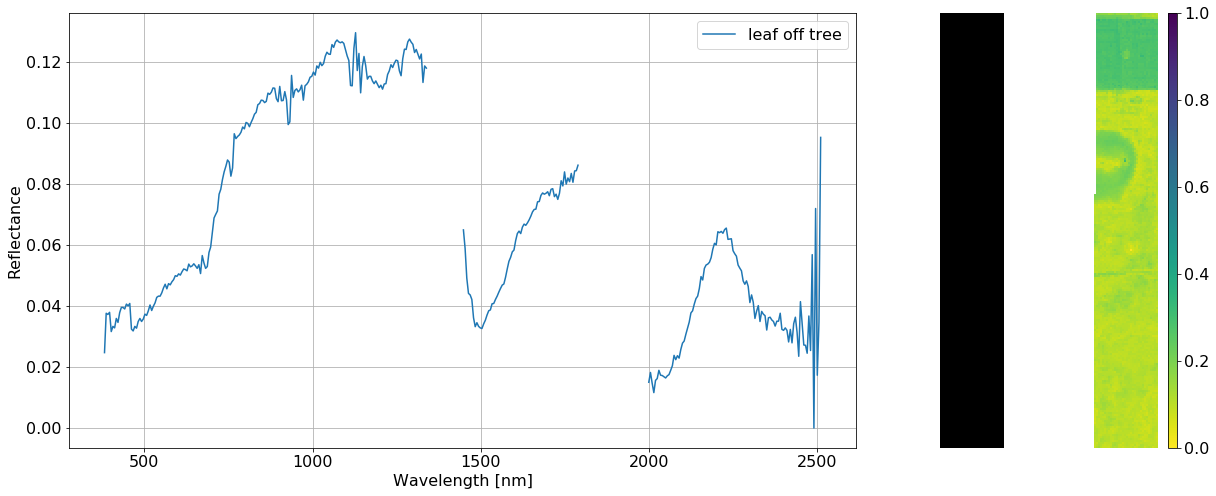

*****************************************************************************
*****************************************************************************
*****************************************************************************
*****************************************************************************


In [31]:
font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 16}

matplotlib.rc('font', **font)

Ue = neon_pt_em
    
# plot them
plt.figure(figsize=(20,10))
for i, em in enumerate(Ue):
    plt.plot(neon_wav, em, label=gdf.comments[i])

plt.title(f'Point Extracted Endmembers from NEON Subset')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Reflectance')
plt.legend()
plt.grid(True)
plt.show()

# Plot the abundance maps
ab_maps = np.array([[SAM(sample, em) for sample in neon_reshp] for em in Ue]).reshape((neon_shp[0], neon_shp[1], 5))

for i,em in enumerate(Ue):
    fig = plt.figure(figsize=(20,8))
    gs = gridspec.GridSpec(1, 3, width_ratios=[8, 1, 1]) 

    ax0 = plt.subplot(gs[0])
    p0 = ax0.plot(neon_wav, em, label=gdf.comments[i])
    ax0.legend()
    ax0.grid(True)
    ax0.set_xlabel('Wavelength [nm]')
    ax0.set_ylabel('Reflectance')

    ax1 = plt.subplot(gs[1])
    im1 = ax1.imshow(bytescale(neon_sub_cube.values[:,:,[54, 34, 22]]))
    ax1.axis('off')

    ax2 = plt.subplot(gs[2])    
    smap = np.array([nansam(em, sample) for sample in neon_reshp]).reshape((neon_shp[0], neon_shp[1]))
    im2 = ax2.imshow(smap, cmap='viridis_r', vmin=0., vmax=1.)
    ax2.axis('off')


    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="15%", pad=0.15)

    plt.colorbar(im2, cax=cax)
    plt.show()

print('*****************************************************************************')
print('*****************************************************************************')
print('*****************************************************************************')
print('*****************************************************************************')

# Try for Headwall

In [19]:
# stack the arrays
gdf_test = gdf_4326

def concat_hw_arrays(hw_pair, dim='band', w_cutoff=896):
    vn, sw = hw_pair
    
    # first check the array sizes, and shave off if needed
    if vn.shape != sw.shape:
        warnings.warn('extracted shapes are not equal, shaving some off...')
        
        min_shape = (min(vn.shape[0], sw.shape[0]), min(vn.shape[1], sw.shape[1]), min(vn.shape[2], sw.shape[2]))
        sw = sw[:min_shape[0], :min_shape[1], :min_shape[2]]
        vn = vn[:min_shape[0], :min_shape[1], :min_shape[2]]
        
    # next, check the x-y offsets. If needed, shift one or the other
    x_offset = np.mean(vn.coords['x'].values - sw.coords['x'].values).ravel()[0]
    y_offset = np.mean(vn.coords['y'].values - sw.coords['y'].values).ravel()[0]
    
#     print(x_offset, y_offset)
#     if (x_offset != 0):
#         sw.assign_coords(x= sw.coords['x'].values + x_offset)
        
#     if (y_offset !=0):
#         sw.assign_coords(y = sw.coords['y'].values + y_offset)
        
    if w_cutoff > 0:
        b_cutoff = np.where(vn.coords['wavelength'] <= w_cutoff)[0][-1] + 1 # +1 due to 1 based indexing on band
        vn = vn.sel(band=slice(0, b_cutoff))
        
    print(vn.shape, sw.shape)
    new_cube = xr.concat((vn,sw), dim=dim, join='left')
    
    return new_cube

def np_concat_hw_arrays(hw_pair, dim='band', w_cutoff=896):
    vn, sw = hw_pair
    
    # first check the array sizes, and shave off if needed
    if vn.shape != sw.shape:
        warnings.warn('extracted shapes are not equal, shaving some off...')
        
        min_shape = (min(vn.shape[0], sw.shape[0]), min(vn.shape[1], sw.shape[1]), min(vn.shape[2], sw.shape[2]))
        sw = sw[:min_shape[0], :min_shape[1], :min_shape[2]]
        vn = vn[:min_shape[0], :min_shape[1], :min_shape[2]]
        
    # next, check the x-y offsets. If needed, shift one or the other
    x_offset = np.mean(vn.coords['x'].values - sw.coords['x'].values).ravel()[0]
    y_offset = np.mean(vn.coords['y'].values - sw.coords['y'].values).ravel()[0]
    
#     print(x_offset, y_offset)
#     if (x_offset != 0):
#         sw.assign_coords(x= sw.coords['x'].values + x_offset)
        
#     if (y_offset !=0):
#         sw.assign_coords(y = sw.coords['y'].values + y_offset)
        
    if w_cutoff > 0:
        b_cutoff = np.where(vn.coords['wavelength'] <= w_cutoff)[0][-1] + 1 # +1 due to 1 based indexing on band
        vn = vn.sel(band=slice(0, b_cutoff))
        
    print(vn.shape, sw.shape)
    new_cube = np.concatenate((vn.values,sw.values))
    coords_dict = {'x': vn.coords['x'].values,
                   'y': vn.coords['y'].values,
                   'band': np.arange(1, new_cube.shape[0]+1)}
    attrs_dict = {'wavelength': np.concatenate((vn.coords['wavelength'].values, sw.coords['wavelength'].values))}
    
    return xr.DataArray(new_cube, dims=('band', 'y', 'x'), coords=coords_dict, attrs=attrs_dict)

def merge_hw_arrays(hw_pair, dim='band', w_cutoff=896):
    vn, sw = hw_pair
    
    # first check the array sizes, and shave off if needed
#     if vn.shape != sw.shape:
#         warnings.warn('extracted shapes are not equal, shaving some off...')
        
#         min_shape = (min(vn.shape[0], sw.shape[0]), min(vn.shape[1], sw.shape[1]), min(vn.shape[2], sw.shape[2]))
#         sw = sw[:min_shape[0], :min_shape[1], :min_shape[2]]
#         vn = vn[:min_shape[0], :min_shape[1], :min_shape[2]]
        
#     # next, check the x-y offsets. If needed, shift one or the other
#     x_offset = np.mean(vn.coords['x'].values - sw.coords['x'].values).ravel()[0]
#     y_offset = np.mean(vn.coords['y'].values - sw.coords['y'].values).ravel()[0]
    
#     if (x_offset != 0):
#         sw.assign_coords(x= sw.coords['x'].values - x_offset)
        
#     if (y_offset !=0):
#         sw.assign_coords(y = sw.coords['y'].values - y_offset)
        
    if w_cutoff > 0:
        b_cutoff = np.where(vn.coords['wavelength'] <= w_cutoff)[0][-1] + 1 # +1 due to 1 based indexing on band
        vn = vn.sel(band=slice(0, b_cutoff))
    
    #interpolate into the higher resolution grid from IMERG
    vn = vn.interp(x=sw["x"], y=sw["y"])
    new_cube = xr.concat([vn, sw])
    
    return new_cube

hw_cube = np_concat_hw_arrays((xarr_VNIR, xarr_SWIR))

(223, 6086, 876) (270, 6086, 876)


C:\software\anaconda3\envs\geo_py\lib\site-packages\ipykernel_launcher.py:40: UserWarning: extracted shapes are not equal, shaving some off...


In [20]:
# extract the endmembers

res=[]
gdf_test2 = gdf_4326.copy()
gdf_test2['geometry'] = gdf_test2.to_crs(epsg=3857).buffer(0.5).to_crs(epsg=4326)

# create mask datasets for the VNIR and SWIR data separately
ds_vnir = xr.Dataset(coords={'y':y_vnir, 'x':x_vnir})
shapes = [(shape, n) for n, shape in enumerate(gdf_test2.geometry)]

temp_vnir = []
for i, shape in enumerate(shapes):

    try:
        ds_vnir['aoi'] = rasterize([shape], ds_vnir.coords)
        ds_vnir['aoi'] = ds_vnir.aoi*0 + 1
        example_vnir = ds_vnir.aoi * xarr_VNIR

        val_y, val_x = np.where(ds_vnir.aoi==1)
        u_y = np.unique(val_y)
        u_x = np.unique(val_x)
        ex_vnir = example_vnir.sel(y=y_vnir[val_y], x=x_vnir[val_x])

        # cut off the VNIR if provided
        w_cutoff = 896
        if w_cutoff > 0:
            b_cutoff = np.where(ex_vnir.coords['wavelength'] <= w_cutoff)[0][-1] + 1 # +1 due to 1 based indexing on band
            ex_vnir = ex_vnir.sel(band=slice(0, b_cutoff))


        if ex_vnir.shape[0] == 0:
            temp_vnir.append(np.zeros((ex_vnir.shape[-1])))
        else:
            #temp_vnir.append(np.squeeze(ex_vnir)) # for points
            temp_vnir.append(np.nanmean(ex_vnir, axis=(0,1))) # for polygons

    except Exception as e:
        print(e)
        print(val_y, val_x, example_vnir.shape)
        print(f'shape {i} is not in VNIR file')
        print('***')

#print(temp_vnir)
vnir_stack = np.vstack(temp_vnir)

# SWIR
ds_swir = xr.Dataset(coords={'y':y_swir, 'x':x_swir})
shapes = [(shape, n) for n, shape in enumerate(gdf_test2.geometry)]

temp_swir = []
for shape in shapes:

    try:
        ds_swir['aoi'] = rasterize([shape], ds_swir.coords)
        ds_swir['aoi'] = ds_swir.aoi*0 + 1
        example_swir = ds_swir.aoi * xarr_SWIR

        val_y, val_x = np.where(ds_swir.aoi==1)
        u_y = np.unique(val_y)
        u_x = np.unique(val_x)
        ex_swir = example_swir.sel(y=y_swir[val_y], x=x_swir[val_x])

        if ex_swir.shape[0] == 0:
            temp_swir.append(np.zeros((ex_swir.shape[-1])))
        else:
            #temp_swir.append(np.squeeze(ex_swir)) # for points
            temp_swir.append(np.nanmean(ex_swir, axis=(0,1))) # for polygons
    except:
        print(e)
        print(val_y, val_x)
        print('shape is not in SWIR file')

swir_stack = np.vstack(temp_swir)

# concatenate the data
full_ex = np.hstack((vnir_stack, swir_stack))


# concatenate the wavelength vectors
full_wav = np.concatenate((ex_vnir.coords['wavelength'].values, ex_swir.coords['wavelength'].values))
full_wav = np.unique(full_wav)

# res.append((full_ex, full_wav)) # for points


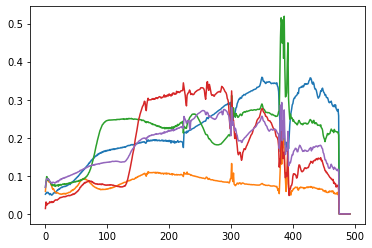

In [21]:
plt.plot(full_ex.T)

In [22]:
U_hw_arr = full_ex

# mask the absorption bands 1340-1445, 1790-1955
hw_i_1340 = np.where(full_wav >= 1340)[0][0]
hw_i_1445 = np.where(full_wav >= 1445)[0][0]
hw_i_1790 = np.where(full_wav >= 1790)[0][0]
hw_i_1995 = np.where(full_wav >= 1995)[0][0]

U_hw_arr[:,hw_i_1340:hw_i_1445] = np.nan
U_hw_arr[:,hw_i_1790:hw_i_1995] = np.nan



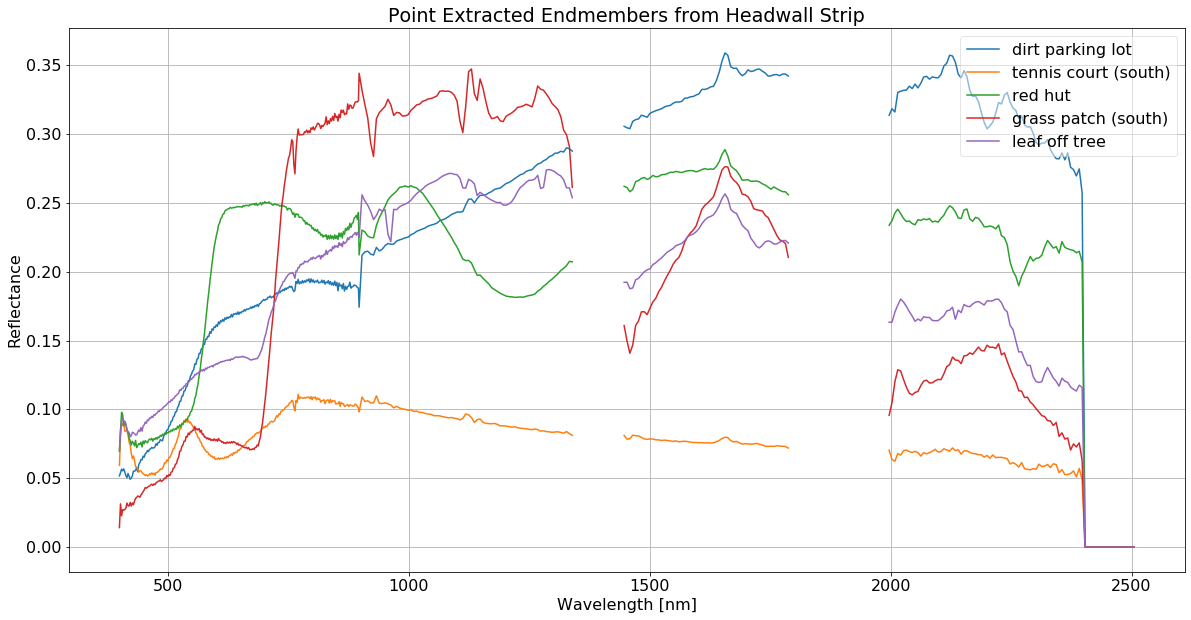

In [36]:
# plot them
plt.figure(figsize=(20,10))
for i,em in enumerate(U_hw_arr):
    plt.plot(full_wav, em, label=gdf_test.comments[i])

plt.title(f'Point Extracted Endmembers from Headwall Strip')
plt.legend(fancybox=True, framealpha=0.5, loc='upper right')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Reflectance')
plt.grid(True)
plt.show()

C:\software\anaconda3\envs\geo_py\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


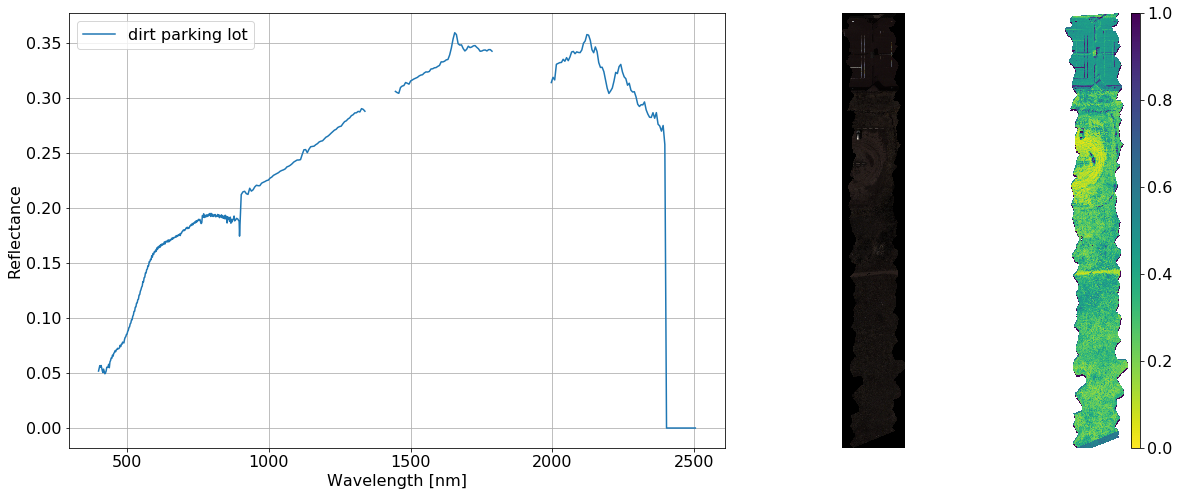

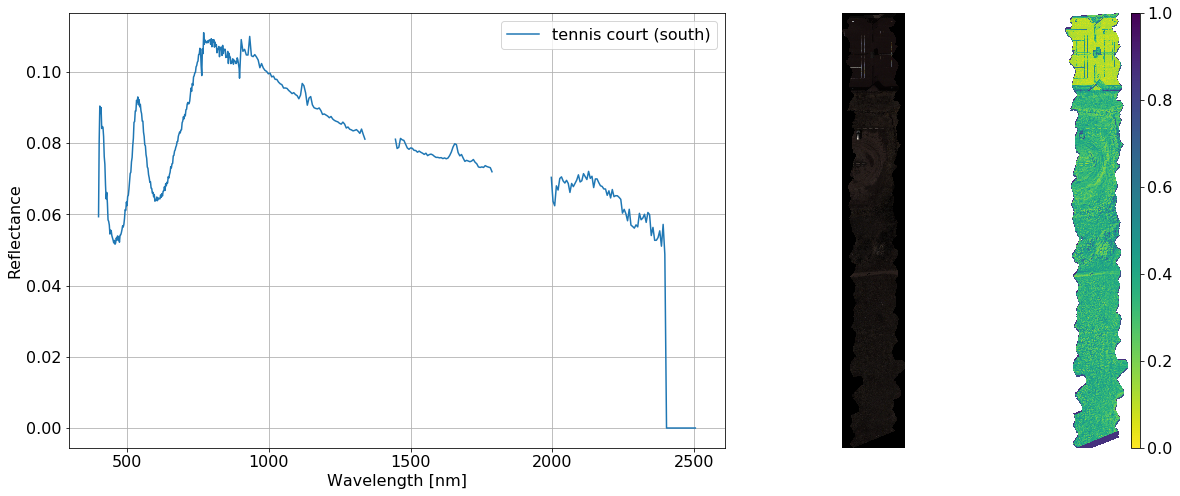

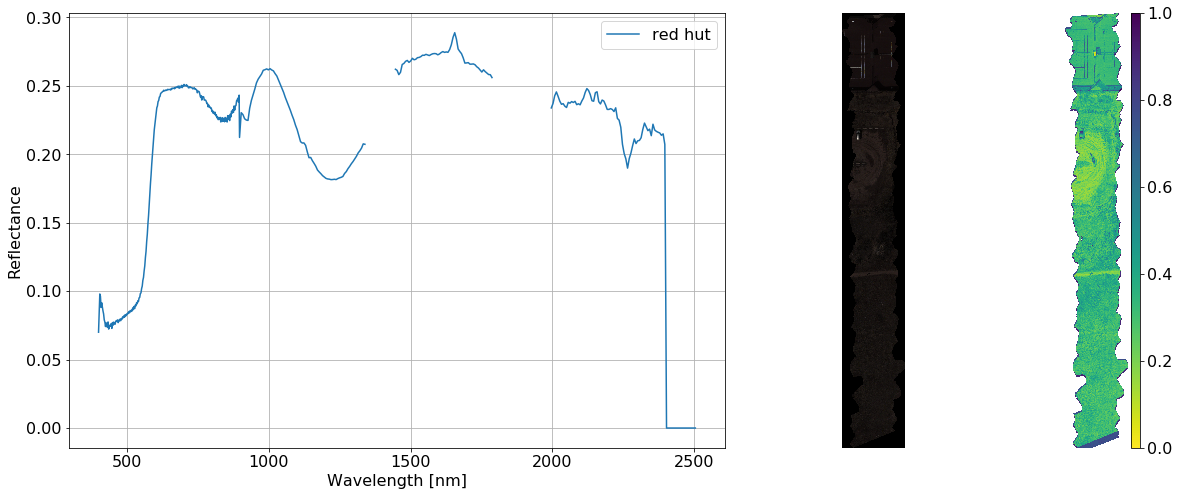

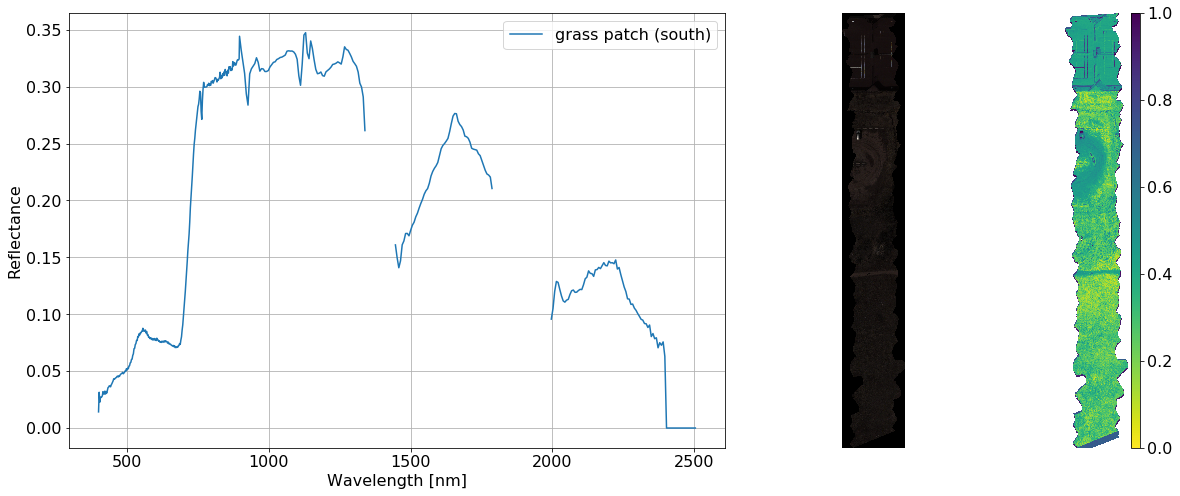

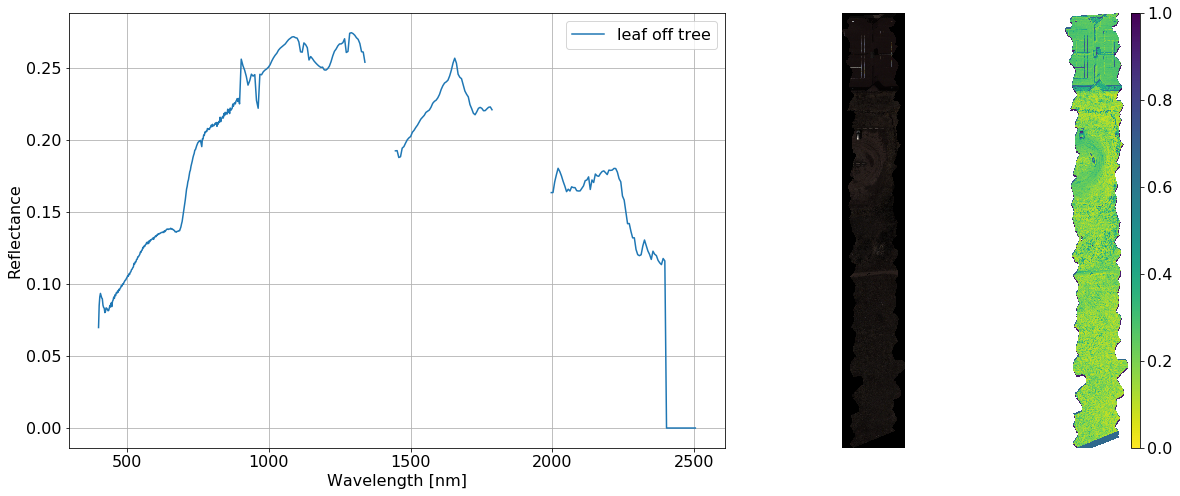

*****************************************************************************
*****************************************************************************
*****************************************************************************
*****************************************************************************


In [35]:
test_plot = hw_cube.transpose('y', 'x', 'band').values
test_plot[:,:, hw_i_1340:hw_i_1445] = np.nan
test_plot[:,:, hw_i_1790:hw_i_1995] = np.nan
hw_shp = test_plot.shape
test_plot1 = test_plot.reshape((hw_shp[0]*hw_shp[1], hw_shp[2]))
test_plot1[~np.isfinite(test_plot1)] = 0

for i,em in enumerate(U_hw_arr):
    fig = plt.figure(figsize=(20,8))
    gs = gridspec.GridSpec(1, 3, width_ratios=[4, 1, 1]) 

    ax0 = plt.subplot(gs[0])
    p0 = ax0.plot(full_wav, em, label=gdf_4326.comments[i])
    ax0.legend()
    ax0.set_xlabel('Wavelength [nm]')
    ax0.set_ylabel('Reflectance')
    ax0.grid(True)

    ax1 = plt.subplot(gs[1])
    im1 = ax1.imshow(bytescale(test_plot[:,:,[54, 34, 22]]))
    ax1.axis('off')
    
    ax2 = plt.subplot(gs[2])
    smap = np.array([nansam(sample, em) for sample in test_plot1]).reshape((hw_shp[0], hw_shp[1]))
    im2 = ax2.imshow(smap, cmap='viridis_r', vmin=0., vmax=1.)
    ax2.axis('off')


    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="15%", pad=0.05)

    plt.colorbar(im2, cax=cax)
    plt.show()

print('*****************************************************************************')
print('*****************************************************************************')
print('*****************************************************************************')
print('*****************************************************************************')

In [25]:
# plot the endmembers against each other
i=0
U_hw_dict = {}
for i,arr in enumerate(U_hw_arr):
    U_hw_dict[gdf_test.comments[i]] = arr
    
  

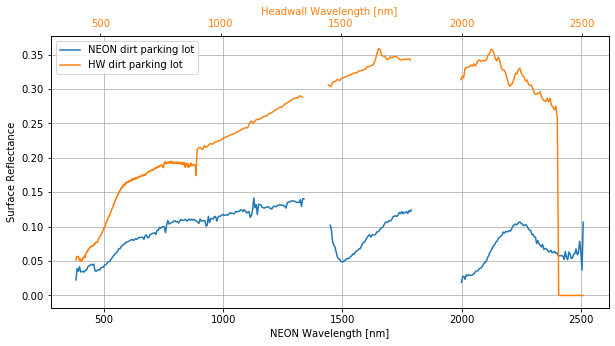

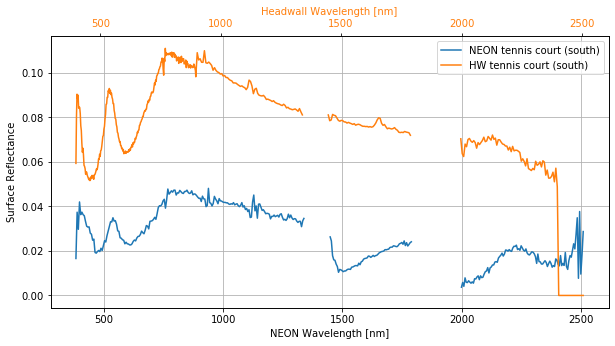

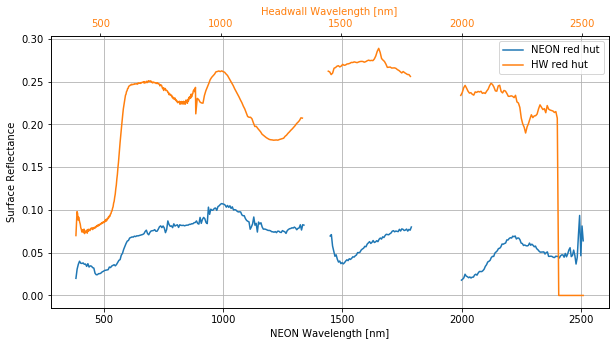

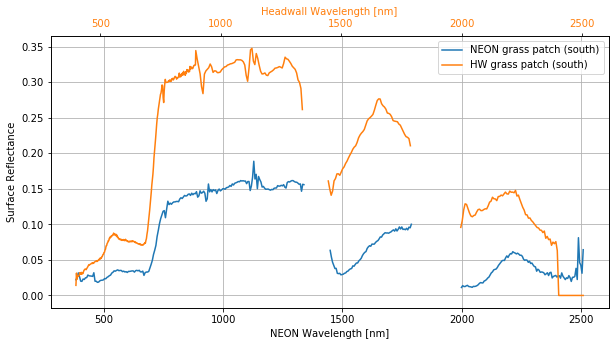

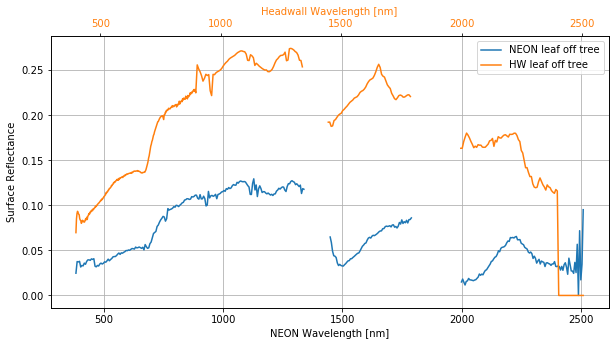

In [27]:
  
for em_n, em_h,k in zip(Ue, U_hw_dict.values(), U_hw_dict.keys()):
    
    fig, ax1 = plt.subplots(figsize=(10,5))
    
    l1 = ax1.plot(neon_wav, em_n, label=f'NEON {k}')
    ax1.set_xlabel('NEON Wavelength [nm]')
    ax2 = ax1.twiny()  # instantiate a second axes that shares the same x-axis

    color = 'tab:orange'
    ax2.set_xlabel('Headwall Wavelength [nm]', color=color)  # we already handled the x-label with ax1
    l2 = ax2.plot(full_wav, em_h, color=color, label=f'HW {k}')
    ax2.tick_params(axis='x', labelcolor=color)
    
    #plt.plot(em_h, label=f'hw {k}')
    
    #ax1.legend()
    #ax2.legend(loc=3)
    
    lns = l1 + l2
    labs = [l.get_label() for l in lns]
    ax2.legend(lns, labs, loc=0)
    
    ax1.grid(True)
    #plt.xlabel('Wavelength [nm]')
    ax1.set_ylabel('Surface Reflectance')
    #plt.grid(True)
    plt.show()
    
    i+=1

# next thing... Subset NEON cube by each headwall cube and calculate spectral angle.

In [28]:
# subset the NEON data with the full extent of headwall data cubes
j=0
for x,y in zip(x_vnir_ls, y_vnir_ls):
    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()
    
    bbox = box(xmin, ymin, xmax, ymax)
    chunk1 = gpd.GeoDataFrame({'geometry':[bbox]}, crs=fiona.crs.from_epsg(4326)).to_crs(epsg=32613)

    neon_sub_cube, neon_arrs = extract_from_NEON((xarr_NEON, x_neon, y_neon), chunk1)
    neon_wav, full_neon = neon_arrs
    
    # some weird nodata stripe
    if j==2:
        neon_sub_cube=neon_sub_cube[1:,1:,:]
        
    # Plot the SAM maps

    for i,em in enumerate(Ue):
        fig = plt.figure(figsize=(20,8))
        gs = gridspec.GridSpec(1, 3, width_ratios=[4, 1, 1]) 

        ax0 = plt.subplot(gs[0])
        p0 = ax0.plot(neon_wav, em, label=gdf.comments[i])
        ax0.legend()
        ax0.grid(True)

        ax1 = plt.subplot(gs[1])
        im1 = ax1.imshow(bytescale(neon_sub_cube.values[:,:,[54, 34, 22]]))

        ax2 = plt.subplot(gs[2])
        neon_shp = neon_sub_cube.shape
        neon_reshp = neon_sub_cube.values.reshape((neon_shp[0]*neon_shp[1], neon_shp[2]))
        smap = np.array([SAM(sample, em) for sample in neon_reshp]).reshape((neon_shp[0], neon_shp[1]))
        im2 = ax2.imshow(smap, cmap='viridis_r')


        divider = make_axes_locatable(ax2)
        cax = divider.append_axes("right", size="15%", pad=0.05)

        plt.colorbar(im2, cax=cax)
        plt.show()

    print('*****************************************************************************')
    print('*****************************************************************************')
    print('*****************************************************************************')
    print('*****************************************************************************')
    
    j+=1

NameError: name 'x_vnir_ls' is not defined

# scribbles


In [ ]:
# need to update helper functions to do this processing if geometries are POINTS
ds_neon = xr.Dataset(coords={'y':y_neon, 'x':x_neon})
shapes = [(shape, n) for n, shape in enumerate(gdf.geometry)]

temp=[]
for shape in shapes:
    ds_neon['aoi'] = rasterize([shape], ds_neon.coords)
    ds_neon['aoi'] = ds_neon.aoi*0 + 1

    example_neon = ds_neon.aoi * xarr_NEON

    val_y, val_x = np.where(ds_neon.aoi==1)
    u_y = np.unique(val_y)
    u_x = np.unique(val_x)
    ex_neon = example_neon.sel(y=y_neon[val_y], x=x_neon[val_x])

    temp.append(ex_neon)
    
# ex_neon.shape, ds_neon['aoi'].shape, example_neon.shape

In [ ]:
from shapely.geometry.point import Point
type(gdf.geometry[0]) is Point

In [ ]:
import pandas as pd


In [ ]:
gps_fi = r"D:\projects\headwall_neon\headwall_data\imu_gps_TM1.txt"
gps_df = pd.read_csv(gps_fi, delimiter='\t')
gps_df.head()

In [ ]:
gps_df['Gps_UTC_Date&Time'].dtype

In [ ]:
# gps_df.plot(y='Gps_UTC_Date&Time')
gps_df.plot(y='Alt', x='Timestamp')

In [ ]:
gps_fi2 = r"D:\projects\headwall_neon\headwall_data\imu_gps_TM2.txt"
gps_df2 = pd.read_csv(gps_fi2, delimiter='\t')
gps_df2.plot(y='Alt', x='Timestamp')

In [ ]:
p1 = gps_df.plot(y='Alt', x='Timestamp', label='flight1')
gps_df2.plot(y='Alt', x='Timestamp', ax=p1, label='flight2')
plt.show()

In [ ]:
hw_wav_ls, full_hw_ls = [], []
for xarr_VNIR, x_vnir, y_vnir, xarr_SWIR, x_swir, y_swir in zip(xarr_VNIR_ls, x_vnir_ls, y_vnir_ls, xarr_SWIR_ls, x_swir_ls, y_swir_ls):
    
    ## do the extraction
    hw_vnir_cube, hw_swir_cube, hw_arrs = extract_from_headwall_ENVI((xarr_VNIR, x_vnir, y_vnir), 
                                                                    (xarr_SWIR, x_swir, y_swir), 
                                                                    pt_df_hw,
                                                                    w_cutoff = 896) #896 is start of SWIR wavelength

    full_wav, full_ex = hw_arrs
    
    hw_wav_ls.append(full_wav)
    full_hw_ls.append(full_ex)

# neon flightlines
neon_wav_ls, full_neon_ls = [],[]
for xarr_NEON, x_neon, y_neon in zip(xarr_NEON_ls, x_neon_ls, y_neon_ls):
    neon_sub_cube, neon_arrs = extract_from_NEON((xarr_NEON, x_neon, y_neon), pt_df_neon)
    neon_wav, full_neon = neon_arrs
    
    neon_wav_ls.append(neon_wav)
    full_neon_ls.append(full_neon)